### Deep Learning Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr

START = '1940-01-01'
END = pd.to_datetime('today')
TICKER = 'GDPC1'

gdp = pdr.get_data_fred(
    TICKER,
    start = START,
    end = END
)

In [2]:
gdp_rate = gdp.pct_change(4).dropna()

#### 1. Recurrent Neural Network

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

SEQ_LENGTH = 12
X, y = create_sequences(gdp_rate.values, SEQ_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [39]:
input_size = 1  # Input feature dimension
hidden_size = 4  # Hidden layer dimension
output_size = 1  # Output dimension
num_layers = 2  # Number of RNN layers
num_epochs = 100
learning_rate = 0.01

model = RNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0015
Epoch [20/100], Loss: 0.0017
Epoch [30/100], Loss: 0.0011
Epoch [40/100], Loss: 0.0008
Epoch [50/100], Loss: 0.0006
Epoch [60/100], Loss: 0.0005
Epoch [70/100], Loss: 0.0005
Epoch [80/100], Loss: 0.0005
Epoch [90/100], Loss: 0.0005
Epoch [100/100], Loss: 0.0005


In [41]:
model.eval()
with torch.no_grad():
    train_pred = model(X_train)
    test_pred = model(X_test)
    train_loss = criterion(train_pred, y_train)
    test_loss = criterion(test_pred, y_test)
    print(f'Train Loss: {train_loss.item():.4f}')
    print(f'Test Loss: {test_loss.item():.4f}')

Train Loss: 0.0005
Test Loss: 0.0005


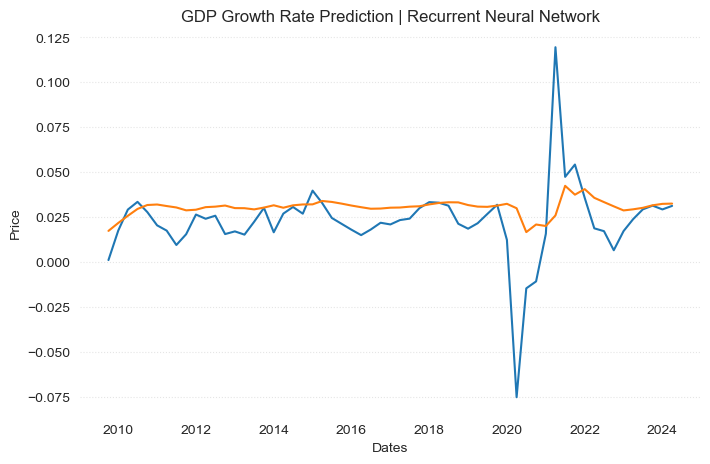

In [42]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    gdp_rate.index[-len(y_test):], 
    y_test.numpy(), 
    label = 'Actual'
)
ax.plot(
    gdp_rate.index[-len(y_test):], 
    test_pred.numpy(), 
    label = 'Predicted'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('GDP Growth Rate Prediction | Recurrent Neural Network')
plt.show()

#### 2. Gated Recurrent Unit

In [43]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [44]:
input_size = 1  
hidden_size = 4
output_size = 1 
num_layers = 2
num_epochs = 500
learning_rate = 0.001

model = GRU(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/500], Loss: 0.0007
Epoch [200/500], Loss: 0.0007
Epoch [300/500], Loss: 0.0006
Epoch [400/500], Loss: 0.0006
Epoch [500/500], Loss: 0.0006


In [46]:
model.eval()
with torch.no_grad():
    train_pred = model(X_train)
    test_pred = model(X_test)
    train_loss = criterion(train_pred, y_train)
    test_loss = criterion(test_pred, y_test)
    print(f'Train Loss: {train_loss.item():.4f}')
    print(f'Test Loss: {test_loss.item():.4f}')

Train Loss: 0.0006
Test Loss: 0.0005


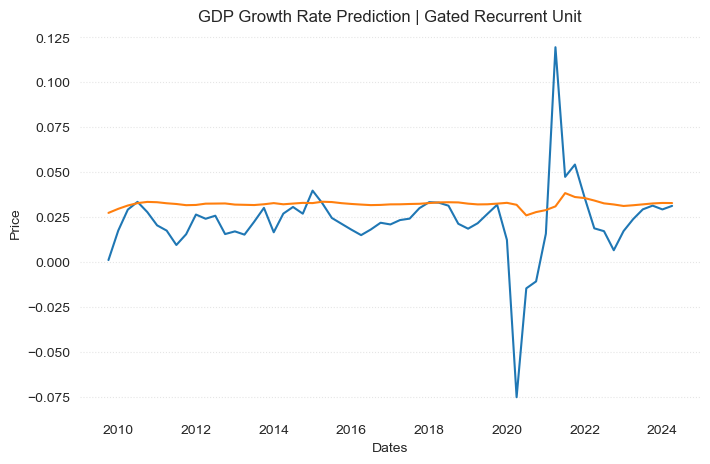

In [47]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    gdp_rate.index[-len(y_test):], 
    y_test.numpy(), 
    label = 'Actual'
)
ax.plot(
    gdp_rate.index[-len(y_test):], 
    test_pred.numpy(), 
    label = 'Predicted'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('GDP Growth Rate Prediction | Gated Recurrent Unit')
plt.show()

#### 3. Long Short Term Memory

In [48]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [81]:
input_size = 1
hidden_size = 32
output_size = 1
num_layers = 2
num_epochs = 500
learning_rate = 0.001

model = LSTM(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [82]:
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [50/500], Loss: 0.0007
Epoch [100/500], Loss: 0.0007
Epoch [150/500], Loss: 0.0007
Epoch [200/500], Loss: 0.0006
Epoch [250/500], Loss: 0.0006
Epoch [300/500], Loss: 0.0006
Epoch [350/500], Loss: 0.0006
Epoch [400/500], Loss: 0.0005
Epoch [450/500], Loss: 0.0004
Epoch [500/500], Loss: 0.0003


In [83]:
model.eval()
with torch.no_grad():
    train_pred = model(X_train)
    test_pred = model(X_test)
    train_loss = criterion(train_pred, y_train)
    test_loss = criterion(test_pred, y_test)
    print(f'Train Loss: {train_loss.item():.4f}')
    print(f'Test Loss: {test_loss.item():.4f}')

Train Loss: 0.0003
Test Loss: 0.0004


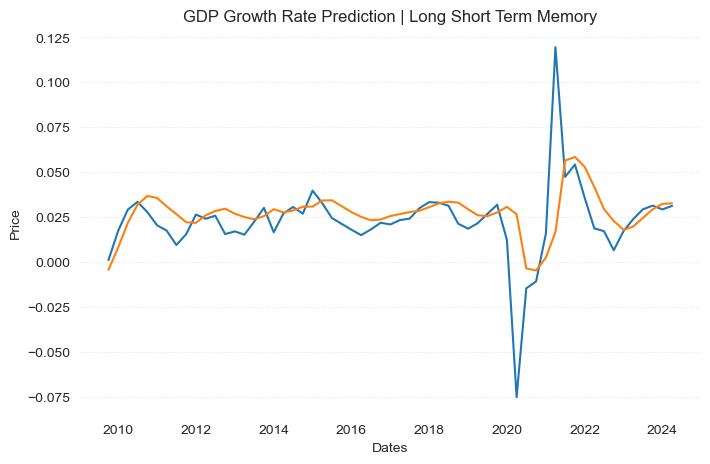

In [84]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    gdp_rate.index[-len(y_test):], 
    y_test.numpy(), 
    label = 'Actual'
)
ax.plot(
    gdp_rate.index[-len(y_test):], 
    test_pred.numpy(), 
    label = 'Predicted'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('GDP Growth Rate Prediction | Long Short Term Memory')
plt.show()